In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model
import keras
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import IsolationForest
import datetime
from scipy.spatial.distance import cosine
import cv2
import os
import numpy as np
import pickle

In [33]:
FACE_DIR = "/content/gdrive/MyDrive/BMA/faces"
EMBEDDINGS_DIR = "/content/gdrive/MyDrive/BMA/face_embeddings"
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


def extract_face(image_path):
    """Extracts the largest detected face from an image"""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None  # No face detected

    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])  # Largest face
    face_roi = gray[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (100, 100))  # Resize to standard size
    return face_resized.flatten()  # Flatten for easier comparison


def register_face(user_id):
    """Registers a new user's face embeddings"""
    user_folder = os.path.join(FACE_DIR, user_id)
    if not os.path.exists(user_folder):
        print(f"No images found for user {user_id}")
        return False

    face_embeddings = []
    for file in os.listdir(user_folder):
        image_path = os.path.join(user_folder, file)
        face = extract_face(image_path)
        if face is not None:
            face_embeddings.append(face)

    if not face_embeddings:
        print(f"No valid faces found for {user_id}")
        return False

    # Save embeddings
    with open(os.path.join(EMBEDDINGS_DIR, f"{user_id}_face.pkl"), "wb") as f:
        pickle.dump(face_embeddings, f)
    print(f"Registered face for {user_id}")
    return True


def verify_face(user_id, test_image_path):
    """Verifies if the test face matches the registered face"""
    embeddings_file = os.path.join(EMBEDDINGS_DIR, f"{user_id}_face.pkl")
    if not os.path.exists(embeddings_file):
        print(f"No registered face for {user_id}")
        return False

    with open(embeddings_file, "rb") as f:
        stored_embeddings = pickle.load(f)


    print(test_image_path)

    test_face = extract_face(test_image_path)
    if test_face is None:
        print("No face detected in test image")
        return False

    # Compare with stored embeddings using cosine similarity
    min_distance = min(np.linalg.norm(test_face - emb) for emb in stored_embeddings)
    print(f"Verification distance: {min_distance}")
    return min_distance < 1500  # Threshold for matching



In [17]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# Custom functions for L1 distance in Siamese Network
@keras.saving.register_keras_serializable()
def l1_distance(embeddings):
    return tf.abs(embeddings[0] - embeddings[1])

@keras.saving.register_keras_serializable()
def l1_distance_output_shape(input_shapes):
    return input_shapes[0]


In [7]:
# Load the pre-trained shared model from Google Drive
def load_trained_model():
  siamese_model = load_model('/content/drive/MyDrive/BMA/siamese_signature_model_v13.keras')
  return siamese_model


In [8]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image = preprocess_input(image)
    return image

In [9]:
# Save embeddings for a user in Google Drive
def save_embeddings(user_id, embeddings):
    embeddings_dir = '/content/drive/MyDrive/BMA/embeddings/'
    os.makedirs(embeddings_dir, exist_ok=True)
    with open(os.path.join(embeddings_dir, f"{user_id}_embeddings.pkl"), 'wb') as f:
        pickle.dump(embeddings, f)

In [10]:
# Load embeddings for a user from Google Drive
def load_user_embeddings(user_id):
    embeddings_file = f'/content/drive/MyDrive/BMA/embeddings/{user_id}_embeddings.pkl'
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

In [11]:
# Generate embeddings using the shared model
def generate_embedding_for_signature(siamese_model, signature_image_path):
    embedding_model = siamese_model.get_layer('embedding_model')  # Extract the embedding model layer
    preprocessed_signature = preprocess_image(signature_image_path)
    embedding = embedding_model.predict(tf.expand_dims(preprocessed_signature, axis=0))  # Generate embedding
    return embedding

In [12]:
# Verify real-world signature with the stored embeddings of a user
def verify_real_world_signature(user_id, siamese_model, live_signature_path, threshold_l1=40, threshold_l2=25, max_l1_distance=100.0):
    # Load stored embeddings (from onboarding)
    stored_embeddings = load_user_embeddings(user_id)

    # Generate embedding for the real-world signature
    new_signature_embedding = generate_embedding_for_signature(siamese_model, live_signature_path)

    # Flatten embeddings
    new_signature_embedding = new_signature_embedding.flatten()
    stored_embeddings_flat = np.array([emb.flatten() for emb in stored_embeddings])

    # Average the stored embeddings
    average_stored_embedding = np.mean(stored_embeddings_flat, axis=0)

    # Calculate L1 distance, Euclidean distance, and cosine similarity
    l1_distance = np.sum(np.abs(average_stored_embedding - new_signature_embedding))
    euclidean_distance = np.linalg.norm(average_stored_embedding - new_signature_embedding)
    cosine_similarity = 1 - cosine(average_stored_embedding, new_signature_embedding)

    # Verification based on L1 distance threshold
    verification_result = "FAILED"
    if l1_distance < threshold_l1:
        verification_result = "VERIFIED"

    # Log distances, cosine similarity, and verification result
    print(f"L1 Distance: {l1_distance}")
    print(f"Euclidean Distance: {euclidean_distance}")
    print(f"Cosine Similarity: {cosine_similarity}")
    print(f"Signature Verification {verification_result} for User {user_id}")

    # Calculate and print similarity score based on L1 distance (optional)
    similarity_score = (1 - (l1_distance / max_l1_distance)) * 100
    print(f"Similarity Score: {similarity_score:.2f}%")

    # Save results to file
    save_verification_results(user_id, live_signature_path, l1_distance, euclidean_distance, cosine_similarity, verification_result)

    return verification_result

In [13]:
# Save verification results to CSV
def save_verification_results(user_id, live_signature_path, l1_distance, euclidean_distance, cosine_similarity, verification_result):
    results_file = '/content/drive/MyDrive/BMA/verification_results.csv'
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    header = not os.path.exists(results_file)  # Write header only if the file doesn't exist
    with open(results_file, 'a') as f:
        if header:
            f.write("Timestamp,User ID,Live Signature Path,L1 Distance,Euclidean Distance,Cosine Similarity,Verification Result\n")
        f.write(f"{timestamp},{user_id},{live_signature_path},{l1_distance},{euclidean_distance},{cosine_similarity},{verification_result}\n")


## Onboard user

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


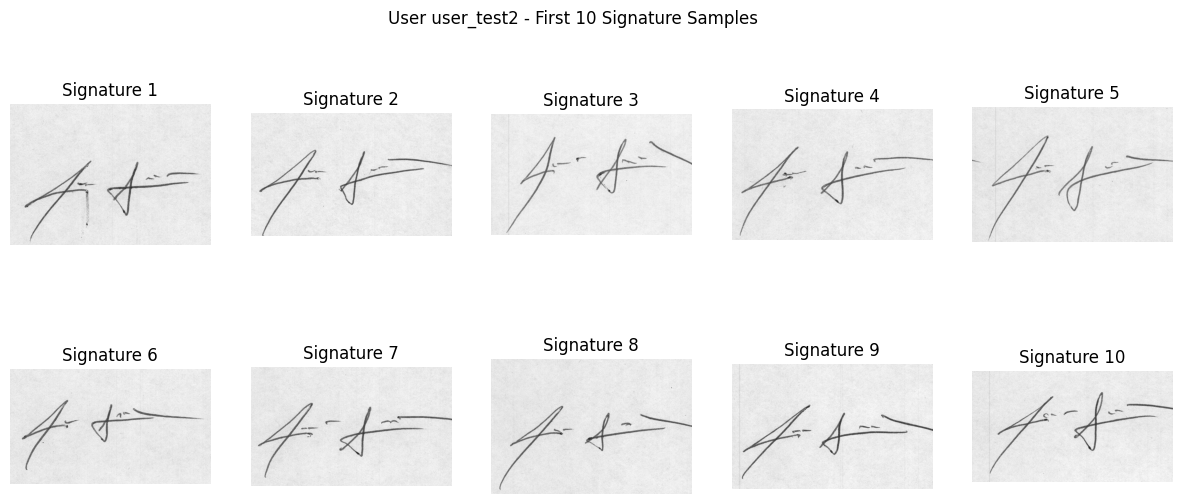

User user_test2 onboarded with 15 embeddings.
Registered face for user_test2


True

In [27]:
# Import necessary libraries for Colab
import tensorflow as tf
import os
import pickle
import numpy as np
from tensorflow.keras.models import load_model
import keras
from google.colab import drive
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

# Path to the base directory in Google Drive where you store models and embeddings
BASE_PATH = '/content/gdrive/MyDrive/BMA'


# Custom L1 distance function for the model
@keras.saving.register_keras_serializable()
def l1_distance(embeddings):
    return tf.abs(embeddings[0] - embeddings[1])

def load_trained_model():
    model_path = os.path.join(BASE_PATH, 'siamese_signature_model_v13.keras')
    return load_model(
        model_path
    )

# Preprocess the signature image using TensorFlow's preprocessing functions
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB

    image = preprocess_input(image)
    return image


# Save embeddings for a user in Google Drive
def save_embeddings(user_id, embeddings):
    embeddings_dir = os.path.join(BASE_PATH, 'embeddings/')
    os.makedirs(embeddings_dir, exist_ok=True)
    with open(os.path.join(embeddings_dir, f"{user_id}_embeddings.pkl"), 'wb') as f:
        pickle.dump(embeddings, f)

# Load embeddings for a user from Google Drive
def load_user_embeddings(user_id):
    embeddings_file = os.path.join(BASE_PATH, f'embeddings/{user_id}_embeddings.pkl')
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

# Generate embeddings using the shared model
def generate_embeddings(signature_image_paths):
    # Load the full Siamese model
    model = load_trained_model()

    # Extract the embedding model (Sequential layer named 'sequential')
    embedding_model = model.get_layer('embedding_model')  # Adjust this based on your embedding model

    embeddings = []
    for path in signature_image_paths:
        # Preprocess the signature image
        processed_signature = preprocess_image(path)

        # Generate the embedding using the embedding model
        embedding = embedding_model.predict(tf.expand_dims(processed_signature, axis=0))
        embeddings.append(embedding)

    return np.array(embeddings)

# Onboard a new user by generating and saving embeddings for their genuine signatures
import os

def onboard_user(user_id, genuine_signature_dir, max_samples=20):
    # Get all genuine signature image paths for the user
    signature_image_paths = [os.path.join(genuine_signature_dir, fname) for fname in os.listdir(genuine_signature_dir)]

    # Limit the number of samples to max_samples (default is 12)
    signature_image_paths = signature_image_paths[:max_samples]

    # Generate embeddings for all genuine signatures (up to max_samples)
    embeddings = generate_embeddings(signature_image_paths)

    # Save the embeddings for the user
    save_embeddings(user_id, embeddings)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(signature_image_paths):
            img = plt.imread(signature_image_paths[i])
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Signature {i+1}')
    plt.suptitle(f'User {user_id} - First 10 Signature Samples')
    plt.savefig(f'/content/gdrive/MyDrive/BMA/signature_samples_{user_id}.png')
    plt.show()

    print(f"User {user_id} onboarded with {len(embeddings)} embeddings.")

# Example usage: Onboarding a user
genuine_signature_dir = '/content/gdrive/MyDrive/BMA/signatures/user_test2/'  # Path to user's genuine signature folder
user_id = 'user_test2'

# Onboard the user and generate embeddings
onboard_user(user_id, genuine_signature_dir)

register_face(user_id)

# Now the embeddings are saved, and you can use them later for verification


## Verify user

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
L1 Distance: 49.543426513671875
Euclidean Distance: 3.3062100410461426
Cosine Similarity: 0.9394760927178322
Signature Verification FAILED for User user_test2
Similarity Score: 50.46%
/content/gdrive/MyDrive/BMA/faces/test/user_test2/test_image.jpeg
Verification distance: 17501.164446973235
Face Not Verified


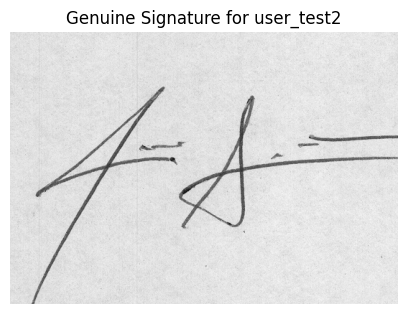

In [37]:
# Example real-world testing
import matplotlib.pyplot as plt

user_id = 'user_test2'  # Replace with your user_id
real_world_signature_path = '/content/gdrive/MyDrive/BMA/live_samples/live_signature_test2_g_1.png'  # Replace with your real-world signature

# Load model
siamese_model = load_trained_model()

# Verify real-world signature
verification_result = verify_real_world_signature(user_id, siamese_model, real_world_signature_path)

result = verify_face(user_id, "/content/gdrive/MyDrive/BMA/faces/test/user_test2/test_image.jpeg")
print("Face Verified:" if result else "Face Not Verified")

# Visualize the real-world signature
img = plt.imread(real_world_signature_path)
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Genuine Signature for {user_id}')
plt.savefig(f'/content/gdrive/MyDrive/BMA/real_world_signature_{user_id}.png')
plt.show()


Forged 1: 1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
L1 Distance: 47.48272705078125
Euclidean Distance: 4.6378865242004395
Cosine Similarity: 0.8231491152126909
Signature Verification VERIFIED for User user_9
Similarity Score: 76.26%

Forged 2: 1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
L1 Distance: 49.42559051513672
Euclidean Distance: 4.712665557861328
Cosine Similarity: 0.8284762604007694
Signature Verification VERIFIED for User user_9
Similarity Score: 75.29%

## Visualize embedding

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


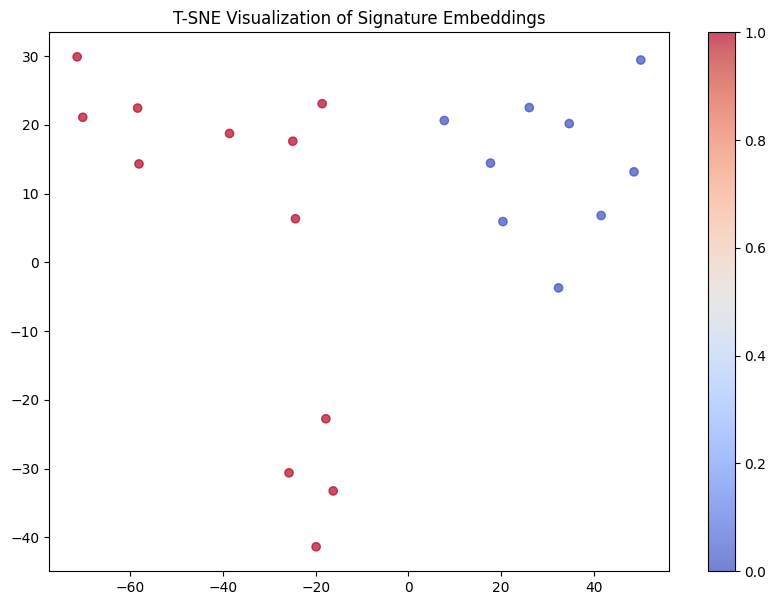

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.colab import drive
import keras

# Mount Google Drive
drive.mount('/content/drive')

# Custom distance function
@keras.saving.register_keras_serializable()
def l1_distance(embeddings):
    return tf.abs(embeddings[0] - embeddings[1])

@keras.saving.register_keras_serializable()
def l1_distance_output_shape(input_shapes):
    return input_shapes[0]  # Same shape as input embeddings

# Load the model from Google Drive
def load_trained_model():
    model_path = '/content/drive/My Drive/BMA/siamese_signature_model_v13.keras'
    return tf.keras.models.load_model(model_path, compile=False)

# Preprocess the signature image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB

    image = preprocess_input(image)
    return image


# Generate embeddings for a list of signature images
def generate_embeddings_for_signatures(signature_image_paths, embedding_model):
    embeddings = []
    for path in signature_image_paths:
        processed_signature = preprocess_image(path)
        embedding = embedding_model.predict(tf.expand_dims(processed_signature, axis=0))
        embeddings.append(embedding)
    return np.array(embeddings)

# T-SNE visualization function
def visualize_embeddings_tsne(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("T-SNE Visualization of Signature Embeddings")
    plt.savefig('/content/drive/My Drive/BMA/tsne_visualization_13_1.png')  # Save visualization to Google Drive
    plt.show()

# Load signatures for visualization (genuine and forged)
def load_signature_image_paths(genuine_dir, forged_dir):
    genuine_image_paths = [os.path.join(genuine_dir, f) for f in os.listdir(genuine_dir) if f.endswith('.png')]
    forged_image_paths = [os.path.join(forged_dir, f) for f in os.listdir(forged_dir) if f.endswith('.png')]
    return genuine_image_paths, forged_image_paths

# Combine genuine and forged for embedding generation
def combine_and_label_data(genuine_paths, forged_paths):
    all_image_paths = genuine_paths + forged_paths
    labels = [0] * len(genuine_paths) + [1] * len(forged_paths)  # 0 for genuine, 1 for forged
    return all_image_paths, labels

# Main function for T-SNE visualization
def generate_and_visualize_embeddings(user_id, siamese_model, genuine_dir, forged_dir):
    # Load the embedding model (the layer used for embeddings)
    embedding_model = siamese_model.get_layer('embedding_model')

    # Load signature image paths
    genuine_image_paths, forged_image_paths = load_signature_image_paths(genuine_dir, forged_dir)

    # Combine and label the data
    all_image_paths, labels = combine_and_label_data(genuine_image_paths, forged_image_paths)

    # Generate embeddings
    embeddings = generate_embeddings_for_signatures(all_image_paths, embedding_model)
    embeddings = embeddings.reshape(len(embeddings), -1)  # Reshape for T-SNE

    # Visualize the embeddings using T-SNE
    visualize_embeddings_tsne(embeddings, labels)

# Example usage
user_id = 'user_10'
genuine_dir = '/content/drive/My Drive/BMA/signatures/user_10/genuine'
forged_dir = '/content/drive/My Drive/BMA/signatures/user_10/forged'
siamese_model = load_trained_model()

# Generate and visualize embeddings with T-SNE
generate_and_visualize_embeddings(user_id, siamese_model, genuine_dir, forged_dir)
